# Copyright Netherlands eScience Center and Centrum Wiskunde & Informatica <br>
** Function     : Emotion recognition and forecast with ConvLSTM** <br>
** Author       : Yang Liu & Tianyi Zhang** <br>
** First Built  : 2020.05.17 ** <br>
** Last Update  : 2020.05.22 ** <br>
** Library      : Pytorth, Numpy, os, DLACs, matplotlib **<br>
Description     : This notebook serves to test the prediction skill of deep neural networks in emotion recognition and forecast. The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Many to one prediction.** <br>

Return Values   : Time series and figures <br>

**This project is a joint venture between NLeSC and CWI** <br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers

# for data loading
import os
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

sys.path.append("C:\\Users\\nosta\\ConvLSTM_emotion\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BBConvLSTM
import dlacs.ConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
datapath = 'C:\\Users\\nosta\\ConvLSTM_emotion\\Data_CASE'
output_path = 'C:\\Users\\nosta\\ConvLSTM_emotion\\results'
model_path = 'C:\\Users\\nosta\\ConvLSTM_emotion\\models'

In [3]:
if __name__=="__main__":
    print ('*********************** extract variables *************************')
    data = np.load(os.path.join(datapath, "data_10s.npz"))
    #data = np.load(os.path.join(datapath, "data_2s.npz"))
    #data = np.load(os.path.join(datapath, "data_0.5s.npz"))
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    sample = data["Samples"][:] # (batch_size, sample_size, channels)
    label_c = data["Labels_c"][:] # (batch_size, sample_size, 2)
    label = data["Labels"][:] # (batch_size, 2)
    subject = data["Subject_id"][:] # (batch_size, 2)
    video_label = data["Video_labels"][:] # (batch_size,1)
    
    # leave-one-out training and testing
    num_s = 2
    sample_train = sample[np.where(subject!=num_s)[0],:,0:5]
    sample_test = sample[np.where(subject==num_s)[0],:,0:5]
    
    label_c_train = label_c[np.where(subject!=num_s)[0],:,:] / 10 # normalize
    label_c_test = label_c[np.where(subject==num_s)[0],:,:] / 10 # normalize

*********************** extract variables *************************


In [4]:
    #################################################################################
    #########                      pre-processing                           #########
    #################################################################################
    # choose the target dimension for reshaping of the signals
    batch_train_size, sample_size, channels = sample_train.shape
    batch_test_size, _, _ = sample_test.shape
    _, _, label_channels = label_c_train.shape
    x_dim = 5
    y_dim = 5
    series_len = sample_size // (y_dim * x_dim)
    # reshape the input and labels
    sample_train_xy = np.reshape(sample_train,[batch_train_size, series_len, y_dim, x_dim, channels])
    sample_test_xy = np.reshape(sample_test,[batch_test_size, series_len, y_dim, x_dim, channels])
    label_c_train_xy = np.reshape(label_c_train,[batch_train_size, series_len, y_dim, x_dim, label_channels])
    label_c_test_xy = np.reshape(label_c_test,[batch_test_size, series_len, y_dim, x_dim, label_channels])
    #################################################################################
    #########                       normalization                           #########
    #################################################################################
    print('================  extract individual variables  =================')
    sample_1 = sample_train_xy[:,:,:,:,0]
    sample_2 = sample_train_xy[:,:,:,:,1]
    sample_3 = sample_train_xy[:,:,:,:,2]
    sample_4 = sample_train_xy[:,:,:,:,3]
    sample_5 = sample_train_xy[:,:,:,:,4]
    
    label_c_valance = label_c_train_xy[:,:,:,:,0]
    label_c_arousal = label_c_train_xy[:,:,:,:,1]
    
    label_c_test_valance = label_c_test_xy[:,:,:,:,0]
    label_c_test_arousal = label_c_test_xy[:,:,:,:,1]
    
    # using indicator for training
    # video_label_3D = np.repeat(video_label[:,np.newaxis,:],series_len,1)
    # video_label_4D = np.repeat(video_label_3D[:,:,np.newaxis,:],y_dim,2)
    # video_label_xy = np.repeat(video_label_4D[:,:,:,np.newaxis,:],x_dim,3)
    # video_label_xy.astype(float)

================  extract individual variables  =================


In [5]:
    # first check of data shape
    print(sample.shape)
    print(label_c.shape)
    print(label.shape)
    print(subject.shape)
    print(video_label.shape)
    # check of reshape
    print(label_c_train_xy.shape)

(3690, 1000, 8)
(3690, 1000, 2)
(3690, 2)
(3690, 1)
(3690, 1)
(3567, 40, 5, 5, 2)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [7]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 5
    hidden_channels = [4, 3, 2] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    learning_rate = 0.01
    num_epochs = 20
    # probability of dropout
    p = 0.5 # 0.5 for Bernoulli (binary) distribution
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print ('*******************  cross validation and testing data  *********************')
    # mini-batch
    mini_batch_size = 64
    # iterations
    iterations = batch_train_size // mini_batch_size
    if batch_train_size % mini_batch_size != 0:
        extra_loop = "True"
        iterations += 1

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************


In [8]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.BBConvLSTM.BBConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(model_path, 'BBconvlstm_emotion_hl_3_kernel_3_lr_0.01_epoch_20_mini_64_validSIC.pkl'),
                                     map_location=device))
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_emotion_hl_1_kernel_3_lr_0.01_epoch_500_validSIC.pkl'))
    print(model)
    # check the sequence length (dimension in need for post-processing)
    _, sequence_len, height, width = sample_1.shape

*******************  load exsited LSTM model  *********************
BBConvLSTM(
  (cell0): BBConvLSTMCell(
    (Wxi): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (dropout): Dropout2d(p=0.5)
  )
  (cell1): BBConvLSTMCell(
    (Wxi): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4,

In [19]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi.weight
tensor([[[[-0.0462,  0.0080, -0.0835],
          [ 0.1415,  0.1050, -0.0149],
          [-0.0819, -0.1153, -0.1139]],

         [[-0.1280,  0.0669,  0.0994],
          [ 0.0641, -0.0091, -0.1008],
          [ 0.0709,  0.0190, -0.1305]],

         [[ 0.1098,  0.0286, -0.0751],
          [ 0.1438,  0.0837,  0.1393],
          [-0.0610, -0.0658,  0.1107]],

         [[ 0.1442,  0.1400, -0.1337],
          [ 0.0109, -0.0077,  0.0062],
          [-0.1268,  0.0479, -0.0059]],

         [[-0.0267,  0.0680, -0.1253],
          [ 0.0656,  0.1415,  0.1333],
          [-0.1431, -0.0730,  0.0952]]],


        [[[ 0.0676,  0.0405, -0.1113],
          [-0.1024,  0.0473, -0.0706],
          [ 0.0761, -0.1360, -0.0666]],

         [[-0.0577, -0.1429, -0.0058],
          [ 0.0075, -0.1271, -0.1442],
          [-0.0007, -0.0369, -0.1170]],

         [[ 0.0250, -0.1097,  0.1011],
          [ 0.0515, -0.0578, -0.0964],
          [ 0.0106, -0.0379, -0.0005]],

         [[-0.1165,  0.0069, 

In [9]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  12
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])
torch.Size([2, 5, 3, 3])
torch.Size([2])
torch.Size([2, 2, 3, 3])


In [9]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    
    # error score for temporal-spatial fields, without keeping spatial pattern
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        It calculates RMSE over the domain, not over time. The spatial structure
        will not be kept.
        Parameter
        ----------------------
        x: input time series with the shape [time, lat, lon]
        """
        x_series = x.reshape(x.shape[0],-1)
        y_series = y.reshape(y.shape[0],-1)
        rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
        rmse_std = np.sqrt(np.std((x_series - y_series)**2,1))
    
        return rmse, rmse_std
    
    # error score for temporal-spatial fields, keeping spatial pattern
    def MAE(x,y):
        """
        Calculate the MAE. x is input series and y is reference series.
        It calculate MAE over time and keeps the spatial structure.
        """
        mae = np.mean(np.abs(x-y),0)
        
        return mae
    
    def MSE(x, y):
        """
        Calculate the MSE. x is input series and y is reference series.
        """
        mse = np.mean((x-y)**2)
        
        return mse

*******************  evaluation matrix  *********************


##############################################################
###################  start prediction loop ###################
##############################################################
*******************  Loss with time  **********************
Wall time: 51.8 s


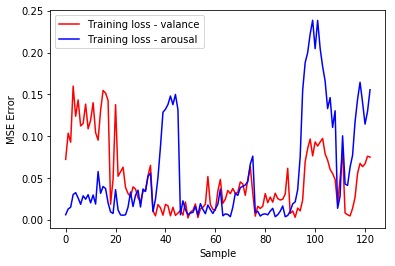

In [11]:
    %%time
    #################################################################################
    ########                           prediction                            ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # forecast array
    pred_valance = np.zeros((batch_test_size, series_len, y_dim, x_dim),dtype=float)
    pred_arousal = np.zeros((batch_test_size, series_len, y_dim, x_dim),dtype=float)
    # calculate loss for each sample
    hist_valance = np.zeros(batch_test_size)
    hist_arousal = np.zeros(batch_test_size)
    for n in range(batch_test_size):
        # Clear stored gradient
        model.zero_grad()
        for timestep in range(sequence_len):
            x_input = np.stack((sample_1[n,timestep,:,:],
                                sample_2[n,timestep,:,:],
                                sample_3[n,timestep,:,:],
                                sample_4[n,timestep,:,:],
                                sample_5[n,timestep,:,:]))
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).to(device)
            # make prediction
            last_pred, _ = model(x_var_pred, timestep)
            # GPU data should be transferred to CPU
            pred_valance[n,timestep,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
            pred_arousal[n,timestep,:,:] = last_pred[0,1,:,:].cpu().data.numpy()
        # compute the error for each sample
        hist_valance[n] = MSE(label_c_test_valance[n,:,:,:], pred_valance[n,:,:,:])
        hist_arousal[n] = MSE(label_c_test_arousal[n,:,:,:], pred_arousal[n,:,:,:]) 
    
    # save prediction as npz file
    np.savez_compressed(os.path.join(output_path,'BBConvLSTM_emotion_pred.npz'),
                        valance=pred_valance, arousal=pred_arousal)
    # plot the error
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist_valance, 'r', label="Training loss - valance")
    plt.plot(hist_arousal, 'b', label="Training loss - arousal")
    plt.xlabel('Sample')
    plt.ylabel('MSE Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'BBConvLSTM_pred_mse_error.png'),dpi=150)    

In [13]:
    #####################################################################################
    ########         visualization of prediction and implement metrics           ########
    #####################################################################################
    # compute mse
    mse_valance = MSE(label_c_test_valance, pred_valance)
    print(mse_valance)
    mse_arousal = MSE(label_c_test_arousal, pred_arousal)
    print(mse_arousal)
    # save output as csv file
    with open(os.path.join(output_path, "MSE_BBConvLSTM_emotion.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["emotion prediction"])  # write header
        writer.writerow(["label valance"])
        writer.writerow([mse_valance])
        writer.writerow(["label arousal"])
        writer.writerow([mse_arousal])

0.04842006886017442
0.05531430360448294


In [ ]:
    %%time
    #################################################################################
    ########                  prediction of single subject                   ########
    #################################################################################
    